# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Imputer, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve

from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


Ratio Nan/not Nan

In [5]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


### To begin we clean the azdias dataframe

In [67]:
# Define the object columns
col_types = azdias.dtypes
col_object = list(col_types[col_types=='object'].index)
col_object

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

In [14]:
pd.to_numeric(customers['CAMEO_DEUG_2015']).replace(-1,np.nan).ffill()

ValueError: Unable to parse string "X" at position 2625

#### These columns contain values such as "X" and "XX". These are turned to NaN's.

In [5]:
azdias[col_object] = azdias[col_object].replace(['XX','X'], np.nan)

## Change the unknowns into NaN's

Some cells contain signs for unkowns. These can be found in the "DIAS Attributes - Values 2017.xlsx" file. Each column of both dataframes is searched for the unknowns and are changed to 'NaN'

In [7]:
### Change unknown values into NaN's
# Read in the excel
xls_dias = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
attri_unknown = xls_dias[xls_dias['Meaning']=='unknown'][['Attribute','Value']]
attri_unknown['Value'] = attri_unknown['Value'].astype(str).str.split(',')

# Change the values from object to numeric
ind = list(attri_unknown.index)
num_val = []
for i in ind:
    num_val.append(pd.to_numeric(attri_unknown['Value'][i]))

# Choose the columns which are in common
attri_unknown['Value_new'] = num_val
attri_unknown = attri_unknown.drop(['Value'], axis=1)
unknowns = dict(attri_unknown.values)
unknowns

{'AGER_TYP': array([-1]),
 'ALTERSKATEGORIE_GROB': array([-1,  0]),
 'ANREDE_KZ': array([-1,  0]),
 'BALLRAUM': array([-1]),
 'BIP_FLAG': array([-1]),
 'CAMEO_DEUG_2015': array([-1]),
 'CAMEO_DEUINTL_2015': array([-1]),
 'CJT_GESAMTTYP': array([0]),
 'D19_KK_KUNDENTYP': array([-1]),
 'EWDICHTE': array([-1]),
 'FINANZTYP': array([-1]),
 'FINANZ_ANLEGER': array([-1]),
 'FINANZ_HAUSBAUER': array([-1]),
 'FINANZ_MINIMALIST': array([-1]),
 'FINANZ_SPARER': array([-1]),
 'FINANZ_UNAUFFAELLIGER': array([-1]),
 'FINANZ_VORSORGER': array([-1]),
 'GEBAEUDETYP': array([-1,  0]),
 'GEOSCORE_KLS7': array([-1,  0]),
 'HAUSHALTSSTRUKTUR': array([-1,  0]),
 'HEALTH_TYP': array([-1]),
 'HH_EINKOMMEN_SCORE': array([-1,  0]),
 'INNENSTADT': array([-1]),
 'KBA05_ALTER1': array([-1,  9]),
 'KBA05_ALTER2': array([-1,  9]),
 'KBA05_ALTER3': array([-1,  9]),
 'KBA05_ALTER4': array([-1,  9]),
 'KBA05_ANHANG': array([-1,  9]),
 'KBA05_ANTG1': array([-1]),
 'KBA05_ANTG2': array([-1]),
 'KBA05_ANTG3': array([-1])

In [6]:
# Get the attributes for which the unknowns have to be set to 'nan'
att_xls = set(unknowns.keys())
att_azdi = set(azdias.columns)

# Check the columns which are common in the xls set and the dataframe
attributes_azdi = sorted(att_azdi & att_xls)
    
for p in attributes_azdi:
    unk = unknowns[p]
    azdias[p] = azdias[p].replace(unk,np.nan)

## Clean the dataframe from the collumns and rows with many NaN's

The columns are searched for the percentage of 'NaN' and are plotted. The columns which contain more than 30% of Nan-values are saved in a list

In [22]:
# Plot the ratios of NaN's in columns
cols_az = list(azdias.columns)

ratios_az = []
columns_2drop_az = []

for col in cols_az:
    rat = azdias[col].isnull().sum()/azdias[col].shape[0]
    ratios_az.append(rat)
    if rat > 0.3:
        columns_2drop_az.append(col)

In [43]:
columns_2drop_az

['ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KK_KUNDENTYP']

Text(0,0.5,'Number of columns')

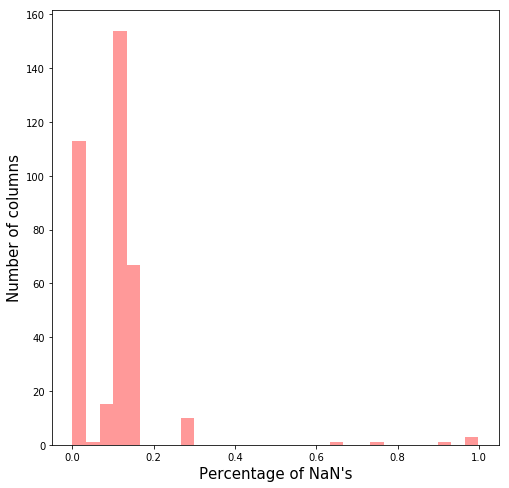

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(ratios_az, bins=30, kde=False, color = 'r')
ax.set_xlabel("Percentage of NaN's",fontsize=15)
ax.set_ylabel("Number of columns",fontsize=15)

In [37]:
sorted(ratios_az, reverse = True)

[0.99864792234473831,
 0.99307691358260186,
 0.96690046576550592,
 0.90904837296248631,
 0.73399639371154857,
 0.65596748730112953,
 0.29504129727643313,
 0.28849522172390463,
 0.28849522172390463,
 0.28849522172390463,
 0.28849522172390463,
 0.28849522172390463,
 0.28849522172390463,
 0.28849522172390463,
 0.28849522172390463,
 0.28849522172390463,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.14959701353536328,
 0.1495970

30% seems to be a good value, since about 10 features are just below 30% and would otherwise be lost if the limit would be lower. 

Now doing the same for the rows.

In [19]:
number_missing = azdias.isnull().sum(axis=1)

Text(0,0.5,'Number of rows')

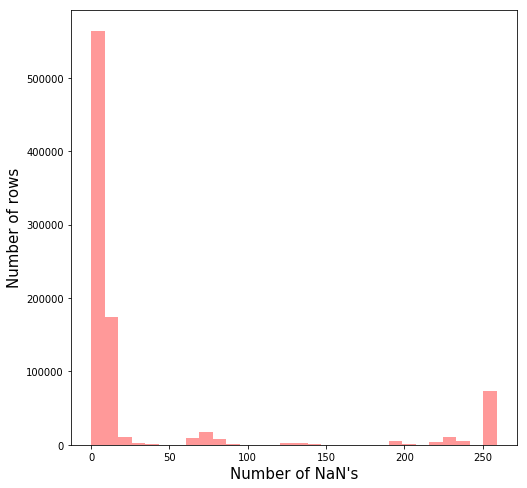

In [44]:
fig, ax = plt.subplots(figsize=(8,8))
sns.distplot(number_missing, bins=30, kde=False, color = 'r')
ax.set_xlabel("Number of NaN's",fontsize=15)
ax.set_ylabel("Number of rows",fontsize=15)

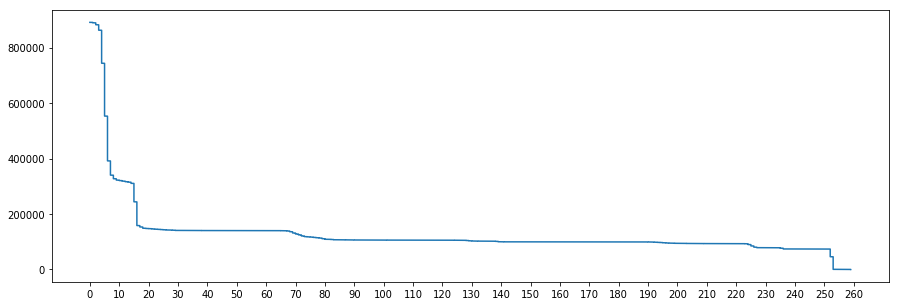

In [64]:
x = sorted(number_missing, reverse = True)
y = np.arange(0,len(x))

plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, 270, step=10))
plt.plot(x,y)

The limit of missing values for each row is set to 21. With this limit not too many rows are droped. 

In [13]:
# set NAN limit for rows
limit = 21

# Remove all rows, which contain more than 20 NaN's for customers
threshold_az = azdias.shape[1]-limit

# Remove all rows, which contain more than 20 NaN's for azdias
mod_azdias = azdias.dropna(axis=0, thresh=threshold_az)

In [14]:
# Delete columns with more than 30% NAN's
mod_azdias = mod_azdias.drop(columns_2drop_az, axis=1)

In [50]:
mod_azdias.shape

(714801, 357)

## Find the columns with many unique values

In [69]:
# Find out which columns have many unique values
columns_unique = azdias[col_object].nunique()

In [75]:
pd.DataFrame(columns_unique, columns= ['Unique values'])

,Unique values
CAMEO_DEU_2015,45
CAMEO_DEUG_2015,19
CAMEO_INTL_2015,43
D19_LETZTER_KAUF_BRANCHE,35
EINGEFUEGT_AM,5162
OST_WEST_KZ,2


In [53]:
mod_azdias[col_object].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W


- EINGEFUEGT_AM: Will be transformed so that only the year is in the column
- OST_WEST_KZ: Transformed to 1 and 0
- D19_LETZTER_KAUF_BRANCHE: Will be droped
- CAMEO_DEU_2015, CAMEO_DEUG_2015, CAMEO_INTL_2015: Have a similar meaning so only the "CAMEO_DEUG_2015" is kept

Additionally there are some columns which contain "Fein" and "Grob". These are similar columns as well, therefore the columns with "Fein" are dropped

In [15]:
# Drop columns which contain double information
drop_double = ['ALTERSKATEGORIE_FEIN','LP_FAMILIE_FEIN','LP_LEBENSPHASE_FEIN','LP_STATUS_FEIN', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
mod_azdias = mod_azdias.drop(drop_double, axis=1)

# Drop columns which contain too many unique values
drop_unique = ['LNR', 'D19_LETZTER_KAUF_BRANCHE']
mod_azdias = mod_azdias.drop(drop_unique, axis=1)

In [16]:
# Change type to numeric, forward fill the missing values
mod_azdias['CAMEO_DEUG_2015'] = pd.to_numeric(mod_azdias['CAMEO_DEUG_2015']).ffill()
mod_azdias['OST_WEST_KZ'] = mod_azdias['OST_WEST_KZ'].replace('W',1).replace('O',0).replace(-1,np.nan)

# Change column 'Eingefuegt am', keep only the year
mod_azdias['EINGEFUEGT_AM'] = pd.to_numeric(mod_azdias['EINGEFUEGT_AM'].str.split('-').str.get(0))

### Cleaning the customers dataframe

In [20]:
#Set the unknowns to NaN
att_cust = set(customers.columns)
customers[col_object] = customers[col_object].replace(['XX','X'], np.nan)

attributes_cust = sorted(att_cust & att_xls)
# Set all values which are referred to unknown to nan
for k in attributes_cust:
    unk = unknowns[k]
    customers[k] = customers[k].replace(unk,np.nan)

customers['GEBURTSJAHR'] = customers['GEBURTSJAHR'].replace(0, np.nan)

# Drop columns which are only in the customer dataframe
col_customers_only = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers = customers.drop(col_customers_only, axis = 1)

#Drop the rows with more 21 missing values
limit = 21
threshold_cus = customers.shape[1]-limit
mod_customers = customers.dropna(axis=0, thresh=threshold_cus)

#Drop the columns
mod_customers = mod_customers.drop(columns_2drop_az, axis=1)
mod_customers = mod_customers.drop(drop_double, axis=1)
mod_customers = mod_customers.drop(drop_unique, axis=1)

mod_customers['CAMEO_DEUG_2015'] = pd.to_numeric(mod_customers['CAMEO_DEUG_2015']).replace(-1,np.nan).ffill()
mod_customers['OST_WEST_KZ'] = mod_customers['OST_WEST_KZ'].replace('W',1).replace('O',0).replace(-1,np.nan).ffill()

# Change column 'Eingefuegt am'
mod_customers['EINGEFUEGT_AM'] = pd.to_numeric(mod_customers['EINGEFUEGT_AM'].str.split('-').fillna('0').str.get(0))

In [21]:
pickle.dump(mod_azdias, open("azdias_cleaned.p","wb"))

In [22]:
pickle.dump(mod_customers, open("customers_cleaned.p","wb"))

## Read in data

In [2]:
customers_cleaned = pickle.load(open("customers_cleaned.p","rb"))
azdias_cleaned = pickle.load(open("azdias_cleaned.p","rb"))

In [4]:
azdias_cleaned.head()

,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,9.0,0.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,1.0,20.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


# Fill in NaN's and standartize columns
The dataframe is split into three parts:
    - The columns which contain binary values
    - The columns which have continuous values
    - The rest of the columns which are numeric
    
There are no categorical columns left. 
Because the Principal componant analysis and k-Means clustering in the further processing is sensitive to data which is not scaled, a "Standard Scaler" is applied on these data.

### 1. Binary columns
- For the missing values the value is imputet which appears the most.

In [5]:
columns_az = azdias_cleaned.columns

In [6]:
col_binary = []
for col in columns_az:
    n_unique = azdias_cleaned[col].dropna().nunique()
    if n_unique == 2:
        col_binary.append(col)

In [5]:
col_binary

['DSL_FLAG',
 'GREEN_AVANTGARDE',
 'HH_DELTA_FLAG',
 'KBA05_SEG6',
 'KONSUMZELLE',
 'OST_WEST_KZ',
 'SOHO_KZ',
 'UNGLEICHENN_FLAG',
 'VERS_TYP',
 'ANREDE_KZ']

In [39]:
#set up the pipline for the binary columns
binary_pipeline = Pipeline([('bin_impute', Imputer(missing_values=np.nan, strategy='most_frequent'))])

### 2. Continuous columns
Some continuous columns do not show a normalized distribution. A "log-transformation" is applied on these columns the rescale them.
- For the missing values the median is imputed.
- Log transformation is applied
- Standard Scaling of the data

In [8]:
# Define the log columns
col_continuous = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL','KBA13_ANZAHL_PKW']

#Skew method to identify logarithmic columns
threshold = 1
skew = customers_cleaned[col_continuous].skew()
skew_cols_cust = list(skew[skew>threshold].index)
skew

ANZ_HAUSHALTE_AKTIV    12.593045
ANZ_HH_TITEL           20.611994
ANZ_PERSONEN            0.933682
ANZ_TITEL               8.287481
KBA13_ANZAHL_PKW        1.205056
dtype: float64

In [9]:
#Skew method to identify logarithmic columns
threshold = 1
skew = azdias_cleaned[col_continuous].skew()
skew_cols = list(skew[skew>threshold].index)
skew

ANZ_HAUSHALTE_AKTIV     8.819908
ANZ_HH_TITEL           22.306192
ANZ_PERSONEN            1.708457
ANZ_TITEL              18.231329
KBA13_ANZAHL_PKW        1.266137
dtype: float64

In [37]:
# Set up continous Pipeline
continuous_pipeline = Pipeline([
    ('log_impute', Imputer(missing_values=np.nan, strategy='median')),
    ('log_transform', FunctionTransformer(np.log1p)),
    ('log_scale', StandardScaler())
])

### 3. Numerical columns
- For the missing values the median is imputed
- Standard Scaling is applied

In [11]:
col_numerical = list(set(azdias_cleaned.columns) - set(col_continuous) - set(col_binary))

In [38]:
# Transform-impute Pipeline
numerical_pipeline = Pipeline([
    ('num_impute', Imputer(missing_values=np.nan, strategy='median',axis=1)),
    ('num_scale', StandardScaler())
])

### Apply all pipelines
A function is created to apply all three pipelines to transform both dataframes.

In [40]:
def transformer(binary_pipeline, continuous_pipeline, numerical_pipeline, df, col_binary, col_continuous, col_numerical):
    
    df_bin = binary_pipeline.fit_transform(df[col_binary])
    df_bin = pd.DataFrame(df_bin, columns=[col_binary])
    
    df_cont = continuous_pipeline.fit_transform(df[col_continuous])
    df_cont = pd.DataFrame(df_cont, columns=[col_continuous])
    
    df_num = numerical_pipeline.fit_transform(df[col_numerical])
    df_num = pd.DataFrame(df_num, columns=[col_numerical])
    
    df_scaled = pd.concat([df_bin, df_cont, df_num], axis=1)
    return df_scaled

In [ ]:
# Transform the azdias dataframe
azdias_transformed = transformer(binary_pipeline, continuous_pipeline, numerical_pipeline, azdias_cleaned, col_binary, col_continuous, col_numerical)

In [17]:
azdias_transformed.head()

,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,OST_WEST_KZ,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,ANREDE_KZ,...,KBA05_GBZ,KBA05_KRSOBER,KBA13_CCM_1800,SEMIO_MAT,D19_REISEN,KBA05_ZUL2,KBA13_SEG_SONSTIGE,KBA05_HERST3,PLZ8_BAUMAX,D19_LOTTO
0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,-1.668272,0.054085,-0.251906,-0.439120,-0.487944,-1.878662,-1.112856,-0.819680,-0.65087,0.449435
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,...,-0.147788,0.054085,1.140534,-0.439120,-0.487944,0.007678,-1.112856,0.072542,-0.65087,-0.700001
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,...,0.612455,0.054085,-0.251906,-1.473986,1.956341,0.007678,-1.112856,0.072542,-0.65087,-0.700001
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,...,-0.147788,0.054085,0.444314,-0.956553,-0.487944,0.950848,2.004355,0.964764,0.03698,-0.700001
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,...,0.612455,0.054085,0.444314,0.078313,-0.487944,0.007678,-0.073786,-1.711901,-0.65087,-0.700001


In [18]:
# Transform the customers dataframe
customers_transformed = transformer(binary_pipeline, continuous_pipeline, numerical_pipeline, customers_cleaned, col_binary, col_continuous, col_numerical)

In [19]:
customers_transformed.head()

,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,OST_WEST_KZ,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,ANREDE_KZ,...,KBA05_GBZ,KBA05_KRSOBER,KBA13_CCM_1800,SEMIO_MAT,D19_REISEN,KBA05_ZUL2,KBA13_SEG_SONSTIGE,KBA05_HERST3,PLZ8_BAUMAX,D19_LOTTO
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.305387,1.569911,0.444586,1.294485,-0.793331,0.980564,1.145242,0.195645,-0.472071,-0.809236
1,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,...,-0.560920,-0.094461,-0.255457,-0.220605,1.192694,0.980564,2.249035,-1.672690,1.220121,1.287543
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.305387,-1.758832,0.444586,0.284425,-0.793331,-0.048863,1.145242,0.195645,-0.472071,-0.809236
3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,...,-0.560920,-0.094461,-1.655544,1.294485,-0.793331,-0.048863,0.041449,0.195645,0.374025,-0.809236
4,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,...,-0.560920,1.569911,-0.255457,-1.230666,-0.793331,-0.048863,-1.062344,-1.672690,-0.472071,1.287543


## Save data

In [21]:
pickle.dump(azdias_transformed, open("azdias_transformed.p","wb"))
pickle.dump(customers_transformed, open("customers_transformed.p","wb"))

In [7]:
#Import transformed dataframes
customers_transformed = pickle.load(open("customers_transformed.p","rb"))
azdias_transformed = pickle.load(open("azdias_transformed.p","rb"))

In [4]:
customers_transformed.shape

(131126, 349)

In [5]:
azdias_transformed.shape

(714801, 349)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1. PCA (Principal Component Analysis), to reduce the number of columns
For an explanation of the PCA visit following link:

https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

Perform a principal component analysis on the azdias dataframe. The limit of the explained variance is set to 95%.

In [4]:
pca = PCA(0.95).fit(azdias_transformed)

Text(0,0.5,'Explained variance ratio')

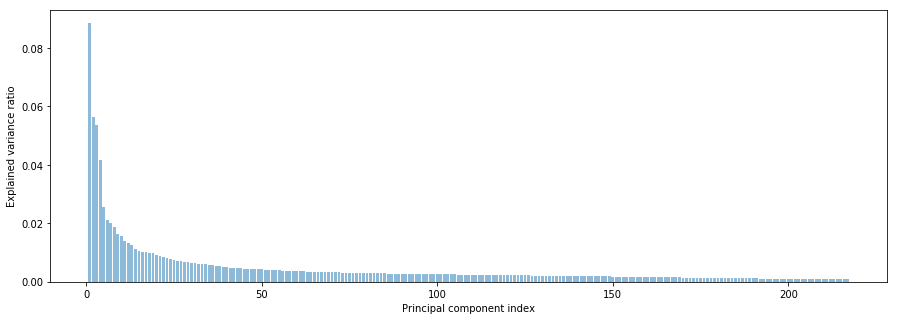

In [5]:
# Plot the variance for the different features
var = pca.explained_variance_ratio_
tot = sum(var)
var_exp = [(i / tot) for i in sorted(var, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(15,5))
plt.bar(range(1,len(var_exp)+1), var_exp, alpha= 0.5, align='center')
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')

In [9]:
#Take 217 features which explaines 95%
n = len(pca.explained_variance_ratio_)
print(str(n) + ' components explain ' + str(sum(pca.explained_variance_ratio_[:n])) + '% of the data.')

217 components explain 0.949486126108% of the data.


In [10]:
col_names = list(azdias_transformed.columns)

In [11]:
# Number of components
n_pcs= pca.components_.shape[0]

# Get the index of the most important feature on each component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

# Get the names
most_important_names = [col_names[most_important[i]] for i in range(n_pcs)]

# Values
variance = pca.explained_variance_ratio_

In [39]:
pca_features = pd.DataFrame({'PCA Feature': [np.arange(1, n_pcs+1)[i] for i in range(n_pcs)], 
                   'Most prominent Feature':most_important_names,'Explained Variance [%]':variance*100})
pca_features.head(10)

,PCA Feature,Most prominent Feature,Explained Variance [%]
0,1,"(MOBI_REGIO,)",8.416281
1,2,"(ONLINE_AFFINITAET,)",5.367604
2,3,"(KBA13_HERST_BMW_BENZ,)",5.088822
3,4,"(FINANZ_SPARER,)",3.968671
4,5,"(KBA13_KW_61_120,)",2.423607
5,6,"(KBA05_SEG2,)",1.999400
6,7,"(SEMIO_KAEM,)",1.917401
7,8,"(KBA13_ALTERHALTER_61,)",1.766336
8,9,"(KBA13_SEG_VAN,)",1.564369
9,10,"(KBA13_ANZAHL_PKW,)",1.481820


In [14]:
# Perform the pca on the azdias_transformed dataframe
pca = PCA(n_components=n).fit(azdias_transformed)
azdias_pca = pd.DataFrame(pca.transform(azdias_transformed))

### 2. K-Means clustering is applied to group the columns and see the differerence between the two dataframes
For a deeper explanation of the K-Means clustering algorithm visit following link:

https://blog.floydhub.com/introduction-to-k-means-clustering-in-python-with-scikit-learn/

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


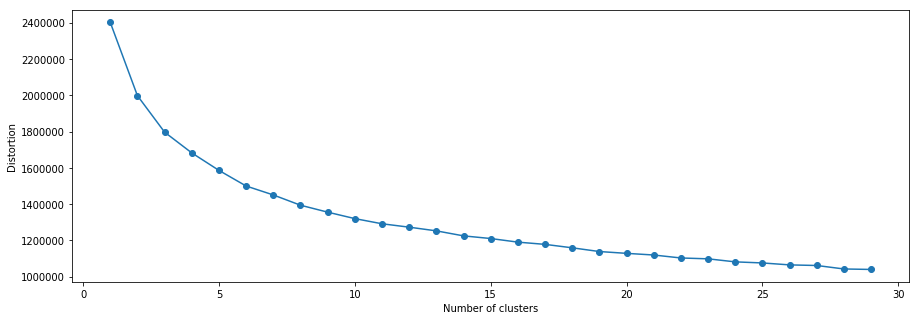

In [33]:
# Using the "Elbow method" to choose the right number of clusters. In this case 12 clusters seem 
#to be a reasonable number; instead of k-means, the k-means++ method is used because it has a better performance
distortions = []
n_cluster = 30
for i in range(1, n_cluster):
    print(i)
    km = KMeans(n_clusters = i,
               init = 'k-means++',
               n_init = 10,
               max_iter = 300,
               random_state = 0)
    km.fit(azdias_pca.sample(20000))
    distortions.append(km.inertia_)

plt.figure(figsize=(15,5))    
plt.plot(range(1,n_cluster), distortions, marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [5]:
# Set PCA and KMeans parameters
number_pca_components = 217
kmeans_clusters = 17

In [10]:
# Create cluster pipeline
cluster_pipeline = Pipeline([
    ('reduce', PCA(n_components = number_pca_components)),
    ('cluster', KMeans(n_clusters = kmeans_clusters, init = 'k-means++'))
])

In [ ]:
# Fit and transform the azdias dataframe with the cluster_pipeline
cluster_pipeline.fit(azdias_transformed)
azdias_clustered = pd.DataFrame(cluster_pipeline.predict(azdias_transformed), columns = ['Cluster'])

In [37]:
# Fit and transform the customers dataframe with the cluster_pipeline
cluster_pipeline.fit(customers_transformed)
customers_clustered = pd.DataFrame(cluster_pipeline.predict(customers_transformed), columns = ['Cluster'])

In [138]:
pickle.dump(customers_clustered, open("customers_clustered.p","wb"))
pickle.dump(azdias_clustered, open("azdias_clustered.p","wb"))

In [3]:
customers_clustered = pickle.load(open("customers_clustered.p","rb"))
azdias_clustered = pickle.load(open("azdias_clustered.p","rb"))

<function matplotlib.pyplot.show(*args, **kw)>

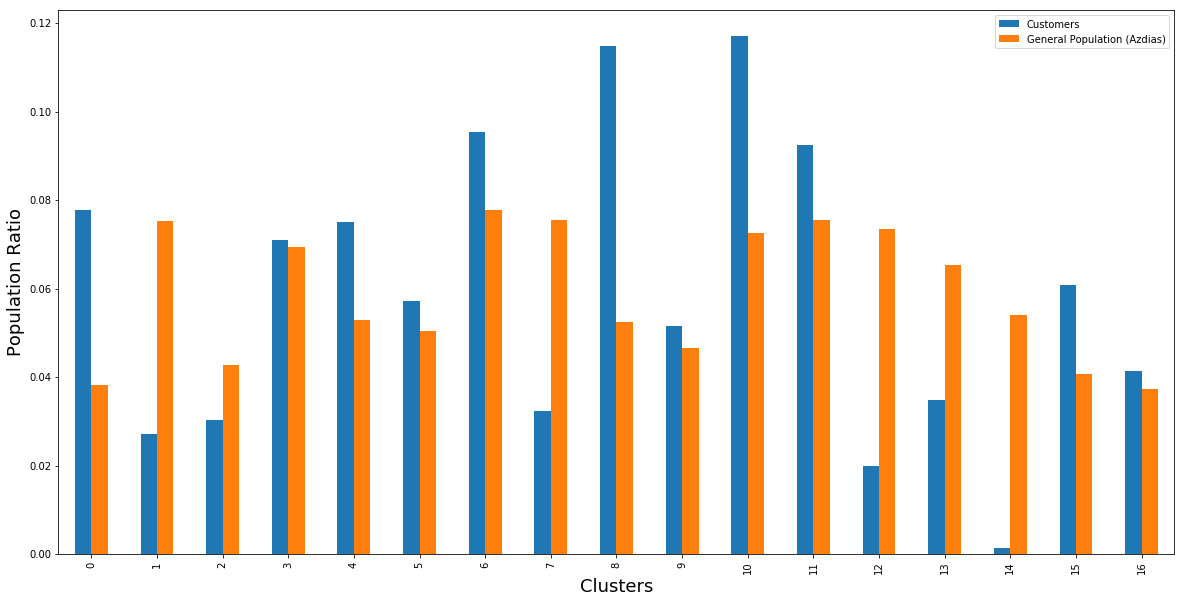

In [8]:
customers = []
azdias = []

# calculate the ratios between the two dataframe for each cluster
for n in range(kmeans_clusters):
    customers.append((customers_clustered == n).sum()/len(customers_transformed))
    azdias.append((azdias_clustered == n).sum()/len(azdias_transformed))

cust = []
az = []
for i in range(kmeans_clusters):
    cust.append(customers[i][0])
    az.append(azdias[i][0])
    
df_clusters = pd.DataFrame({"Clusters" : list(range(kmeans_clusters)) , "Customers" : cust , "General Population (Azdias)": az})

df_clusters.plot(x= 'Clusters', y = ["Customers", "General Population (Azdias)"], kind = "bar", figsize = (20,10))
plt.ylabel('Population Ratio', fontsize=18)
plt.xlabel("Clusters", fontsize=18)
plt.show

In [9]:
# Perform an inverse tranformation 
col_names = list(azdias_transformed.columns)
pca_components = cluster_pipeline.named_steps['reduce']
kmeans = cluster_pipeline.named_steps['cluster']

cluster_centers = pca_components.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=col_names)

NameError: name 'cluster_pipeline' is not defined

Save cluster centers

In [129]:
pickle.dump(cluster_centers_df, open("cluster_centers_df.p","wb"))

In [2]:
cluster_centers_df = pickle.load(open("cluster_centers_df.p","rb"))

FileNotFoundError: [Errno 2] No such file or directory: 'cluster_centers_df.p'

Compare the two dataframes regarding the cluster centers

In [56]:
comparison_df = cluster_centers_df.T[[0,8,1,7]]
comparison_df.columns=['int (cl 0)','int (cl 8)','not int (cl 1)','not int (cl 7)']
comp_big = comparison_df[comparison_df.std(axis=1)>1.]
comp_big

,int (cl 0),int (cl 8),not int (cl 1),not int (cl 7)
"(ANZ_HAUSHALTE_AKTIV,)",-0.415182,-0.463322,2.770346,1.424348
"(KBA05_ANTG1,)",0.408319,0.444556,-1.519769,-1.308717
"(LP_STATUS_GROB,)",0.510364,0.279823,-1.476219,-1.362496
"(ANZ_STATISTISCHE_HAUSHALTE,)",-0.223567,-0.219495,3.166794,0.525851
"(CJT_TYP_4,)",-0.056483,0.280446,0.397033,-1.819227
"(FINANZ_VORSORGER,)",0.134603,0.322389,0.362296,-1.942570
"(MOBI_REGIO,)",0.399232,0.557251,-1.995412,-1.442718
"(FINANZ_SPARER,)",-0.192428,-0.334927,-0.290936,2.094018
"(CJT_TYP_1,)",-0.023973,-0.307775,-0.299486,1.890030
"(KBA13_BAUMAX,)",-0.328660,-0.490184,1.127205,1.761072


In [57]:
comparison_df = cluster_centers_df.T[[0,8,12,14]]
comparison_df.columns=['int (cl 0)','int (cl 8)','not int (cl 12)','not int (cl 14)']
comp_big = comparison_df[comparison_df.std(axis=1)>1.]
comp_big

,int (cl 0),int (cl 8),not int (cl 12),not int (cl 14)
"(D19_BANKEN_DATUM,)",-0.046992,0.331870,-2.064062,-0.002962
"(D19_TELKO_ONLINE_DATUM,)",-0.024212,0.056025,-0.008725,-20.639122
"(D19_TELKO_DATUM,)",-0.222744,0.281551,-2.992833,-3.470319
"(D19_VERSI_ONLINE_QUOTE_12,)",-0.004019,0.007377,0.030589,2.072527
"(D19_BANKEN_ANZ_12,)",-0.129397,-0.240050,1.944039,-0.199249
"(D19_VERSI_OFFLINE_DATUM,)",0.026531,0.148641,-4.825927,0.081475
"(D19_BANKEN_OFFLINE_DATUM,)",-0.079551,0.183177,-4.479505,-0.156558
"(D19_TELKO_OFFLINE_DATUM,)",-0.082281,0.206744,-4.355270,-0.000908
"(D19_TELKO_ANZ_12,)",0.003932,-0.169028,3.323119,5.813705
"(D19_GESAMT_ANZ_12,)",0.839818,-0.607904,1.957900,0.878568


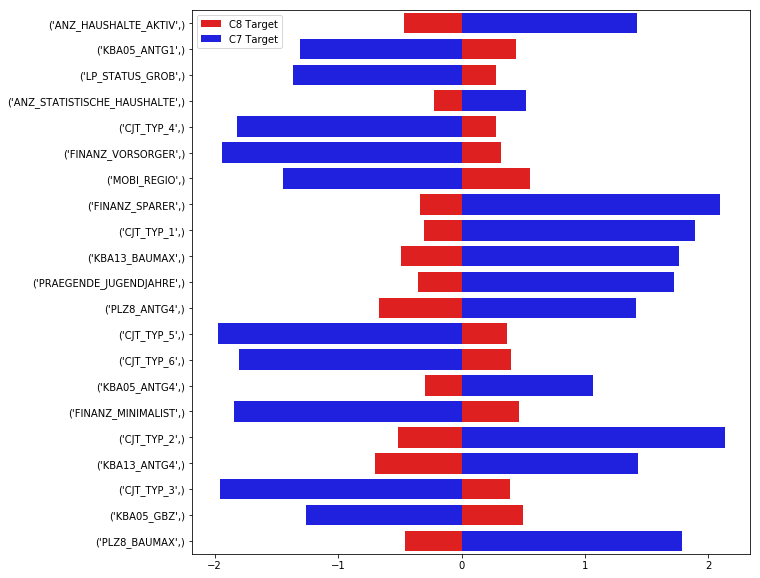

In [53]:
plt.figure(figsize=(10,10))

sns.barplot(x=test['interested (cl 8)'], y=test['interested (cl 8)'].index, label="C8 Target", color='r')
sns.barplot(x=test['not interested (cl 7)'], y=test['not interested (cl 7)'].index, label="C7 Target", color='b')
plt.xlabel('')
plt.legend(loc="upper left");

The customers tend:
- to live in housholds with few people
- live in regions with low mobility
- to have one or several cars
- to have a high salary with an interest in investing and saving money

To summarize, the customers seem to be in the middle to upper class.